# Demo EEFxTMS_2F (equatorial electric field)

> Authors: Ashley Smith
>
> Abstract: Access to the equatorial electric field (level 2 product).

In [1]:
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

2021-01-24T15:47:30+00:00

CPython 3.7.6
IPython 7.11.1

viresclient 0.7.1
pandas 0.25.3
xarray 0.15.0
matplotlib 3.1.2


In [2]:
from viresclient import SwarmRequest
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

request = SwarmRequest()

## EEFxTMS_2F product information

Dayside equatorial electric field, sampled at every dayside equator crossing +- 20mins


Documentation:
- https://earth.esa.int/web/guest/missions/esa-eo-missions/swarm/data-handbook/level-2-product-definitions#EEFxTMS_2F

### Check what "EEF" data variables are available

In [3]:
request.available_collections("EEF", details=False)

{'EEF': ['SW_OPER_EEFATMS_2F', 'SW_OPER_EEFBTMS_2F', 'SW_OPER_EEFCTMS_2F']}

In [4]:
request.available_measurements("EEF")

['EEF', 'EEJ', 'RelErr', 'Flags']

## Fetch all the EEF and EEJ values from Bravo during 2016

In [5]:
request.set_collection("SW_OPER_EEFBTMS_2F")
request.set_products(measurements=["EEF", "EEJ", "Flags"])
data = request.get_between(
    dt.datetime(2016,1,1),
    dt.datetime(2017,1,1)
)

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:03, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (3.834MB)


In [6]:
# The first three and last three source (daily) files
data.sources[:3], data.sources[-3:]

(['SW_OPER_EEFBTMS_2F_20160101T000000_20160101T235959_0203',
  'SW_OPER_EEFBTMS_2F_20160102T000000_20160102T235959_0203',
  'SW_OPER_EEFBTMS_2F_20160103T000000_20160103T235959_0203'],
 ['SW_OPER_EEFBTMS_2F_20161229T000000_20161229T235959_0203',
  'SW_OPER_EEFBTMS_2F_20161230T000000_20161230T235959_0203',
  'SW_OPER_EEFBTMS_2F_20161231T000000_20161231T235959_0203'])

In [7]:
df = data.as_dataframe()
df.head()

Spacecraft  \
Timestamp                                  
2016-01-01 00:52:23.367156267          B   
2016-01-01 02:27:06.243671894          B   
2016-01-01 04:02:03.629109383          B   
2016-01-01 05:36:43.555203199          B   
2016-01-01 07:10:49.341007710          B   

                                                                             EEJ  \
Timestamp                                                                          
2016-01-01 00:52:23.367156267  [-73.90588074073482, -60.11930877820174, -46.6...   
2016-01-01 02:27:06.243671894  [-47.515081717599315, -42.82799969485087, -38....   
2016-01-01 04:02:03.629109383  [3.736902872690357, 3.9969603578212474, 4.2560...   
2016-01-01 05:36:43.555203199  [-3.2799145466292767, -2.6218449989871813, -1....   
2016-01-01 07:10:49.341007710  [0.753534681815288, 1.52551827324165, 2.296329...   

                                    EEF   Latitude  Flags   Longitude  
Timestamp                                                              
2016-01-01 00:52:23.367156267 -0.404194   7.290433      0  113.754512  
2016-01-01 02:27:06.243671894 -0.192555   7.577520      0   89.980167  
2016-01-01 04:02:03.629109383 -0.111413   6.948012      0   66.182831  
2016-01-01 05:36:43.555203199 -0.183012   7.422034      0   42.413424  
2016-01-01 07:10:49.341007710 -0.072057  10.052089      0   18.699167

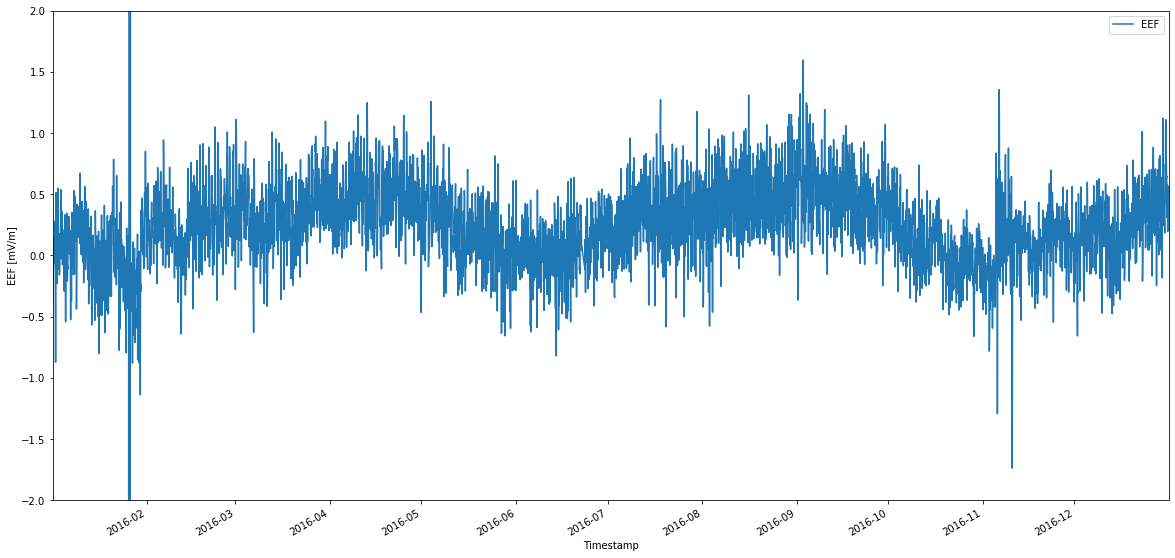

In [8]:
ax = df.plot(y="EEF", figsize=(20,10))
ax.set_ylim((-2, 2));
ax.set_ylabel("EEF [mV/m]");

Take a look at the time jumps between entries... Nominally the product should produce one measurement "every dayside equator crossing ±20 minutes"

In [9]:
times = df.index
delta_t_minutes = [t.seconds/60 for t in np.diff(times.to_pydatetime())]
print("Range of time gaps (in minutes) between successive measurements:")
np.unique(np.sort(delta_t_minutes))

Range of time gaps (in minutes) between successive measurements:


array([  46.3       ,   46.4       ,   91.48333333,   91.5       ,
         91.51666667,   91.53333333,   91.55      ,   91.56666667,
         91.58333333,   91.6       ,   91.61666667,   91.63333333,
         91.65      ,   91.66666667,   91.68333333,   91.7       ,
         91.71666667,   91.73333333,   91.75      ,   91.76666667,
         91.78333333,   91.8       ,   91.81666667,   91.83333333,
         91.85      ,   91.86666667,   91.88333333,   91.9       ,
         91.91666667,   91.93333333,   91.95      ,   91.96666667,
         91.98333333,   92.        ,   92.01666667,   92.03333333,
         92.05      ,   92.06666667,   92.08333333,   92.1       ,
         92.11666667,   92.13333333,   92.15      ,   92.16666667,
         92.18333333,   92.2       ,   92.21666667,   92.23333333,
         92.25      ,   92.26666667,   92.28333333,   92.3       ,
         92.31666667,   92.33333333,   92.35      ,   92.36666667,
         92.38333333,   92.4       ,   92.41666667,   92.43333

## Access the EEJ estimate via xarray instead of pandas

Since the EEJ estimate has both time and latitude dimensions, it is not suited to pandas. Here we load the data as a `xarray.Dataset` which better handles n-dimensional data.

In [10]:
ds = data.as_xarray()
ds

<xarray.Dataset>
Dimensions:     (EEJ_QDLat: 81, Timestamp: 5508)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2016-01-01T00:52:23.367156267 ... 2016-12-31T23:20:06.076265574
  * EEJ_QDLat   (EEJ_QDLat) float64 -20.0 -19.5 -19.0 -18.5 ... 19.0 19.5 20.0
Data variables:
    Spacecraft  (Timestamp) object 'B' 'B' 'B' 'B' 'B' ... 'B' 'B' 'B' 'B' 'B'
    Longitude   (Timestamp) float64 113.8 89.98 66.18 ... -105.3 -129.1 -153.0
    Flags       (Timestamp) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    EEJ         (Timestamp, EEJ_QDLat) float64 -73.91 -60.12 ... -7.573 -9.667
    EEF         (Timestamp) float64 -0.4042 -0.1926 -0.1114 ... 0.4747 0.5628
    Latitude    (Timestamp) float64 7.29 7.578 6.948 ... -7.722 -4.006 -0.7652
Attributes:
    Sources:         ['SW_OPER_EEFBTMS_2F_20160101T000000_20160101T235959_020...
    MagneticModels:  []
    RangeFilters:    []

Let's select a subset (one month) and visualise it:

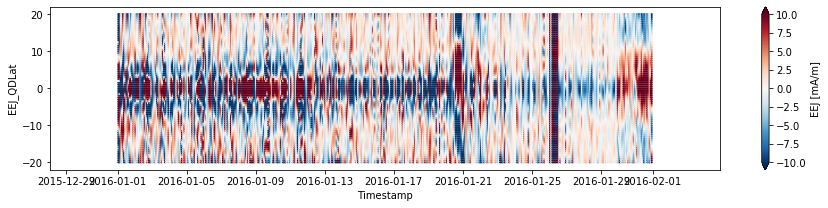

In [11]:
_ds = ds.sel({"Timestamp": "2016-01"})

fig, ax1 = plt.subplots(nrows=1, figsize=(15,3), sharex=True)
_ds.plot.scatter(x="Timestamp", y="EEJ_QDLat", hue="EEJ", vmax=10, s=1, ax=ax1)